### Business Problem: Crop Recommendation for Farmers
Farmers often struggle to determine the best crop to grow based on soil nutrients, weather conditions, and rainfall patterns. Incorrect crop selection can lead to poor yield, financial losses, and inefficient resource utilization. This project aims to build a Crop Recommendation System that leverages machine learning to analyze soil and environmental factors, helping farmers make informed decisions for better productivity and sustainability.

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

### Data Exploration

In [2]:
# Load the dataset
df = pd.read_csv('Crop_recommendation.csv')
df.head()

N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

In [3]:
df.shape

(2200, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [5]:
df.dtypes

N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

In [6]:
# Check for null values
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [7]:
# Summary Statistics
df.describe()

N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469480   103.463655  
std       0.773938    54.958389  
min       3.504752    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508  
max       9.935091   298.560117

### Exploratory Data Analysis

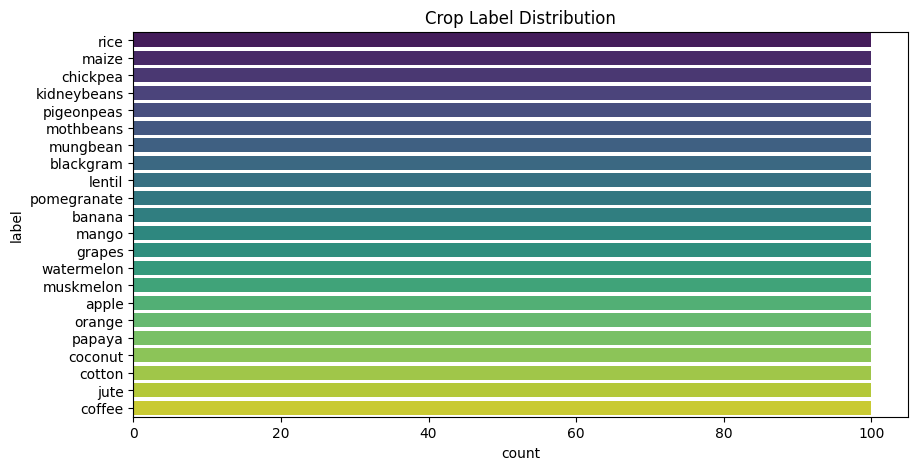

In [8]:
# Label Distribution
plt.figure(figsize=(10, 5))
sns.countplot(y=df["label"], palette="viridis")
plt.title("Crop Label Distribution")
plt.show()

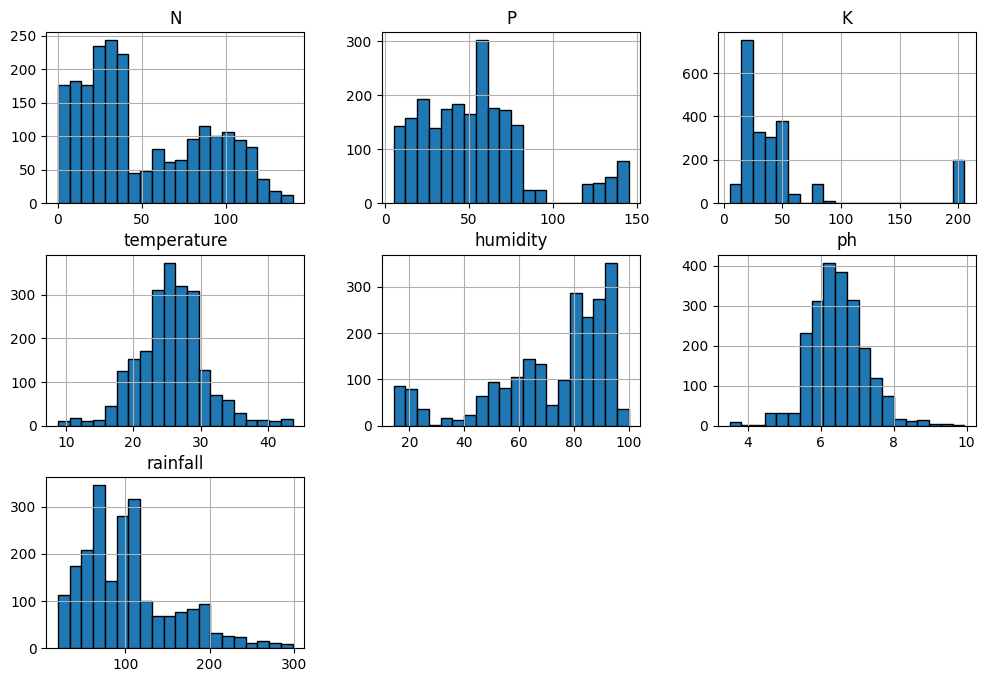

In [9]:
# Distribution of Numerical Columns
df.hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.show()

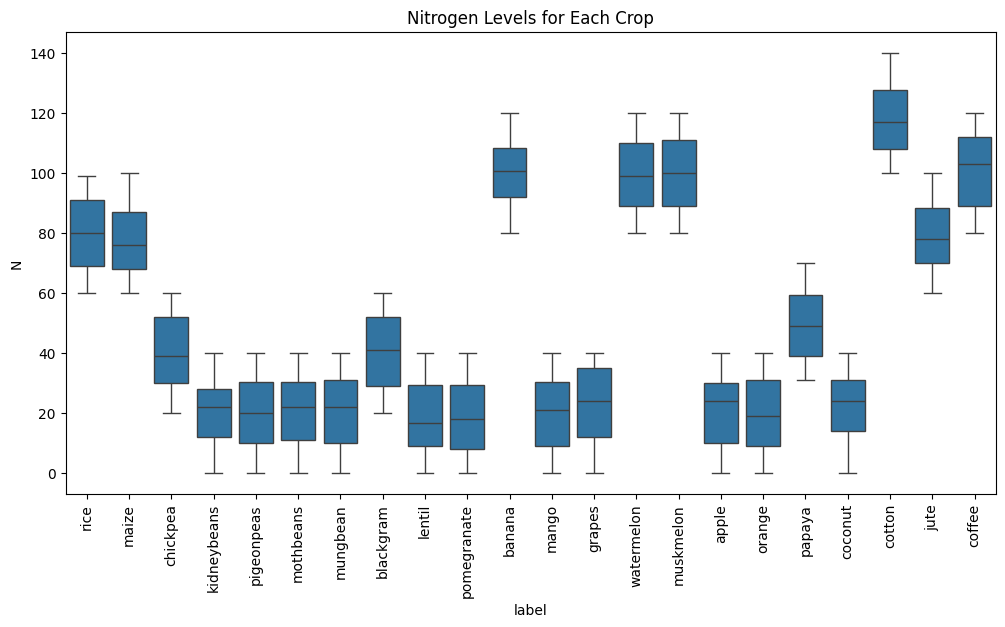

In [10]:
# Distribution of Nitrogen levels for each crop
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["label"], y=df["N"])
plt.title("Nitrogen Levels for Each Crop")
plt.xticks(rotation=90)
plt.show()

The above plot shows how nitrogen levels vary across crops. Crops like rice,maize,banana,watermelon,muskmelon,cotton jute and coffee need more nitrogen, while pulses and some fruits require less.The spread of nitrogen values also indicates natural variation in soil conditions for these crops.Farmers can use this insight to optimize fertilizer use, ensuring crops receive the right amount of nitrogen for healthy growth.

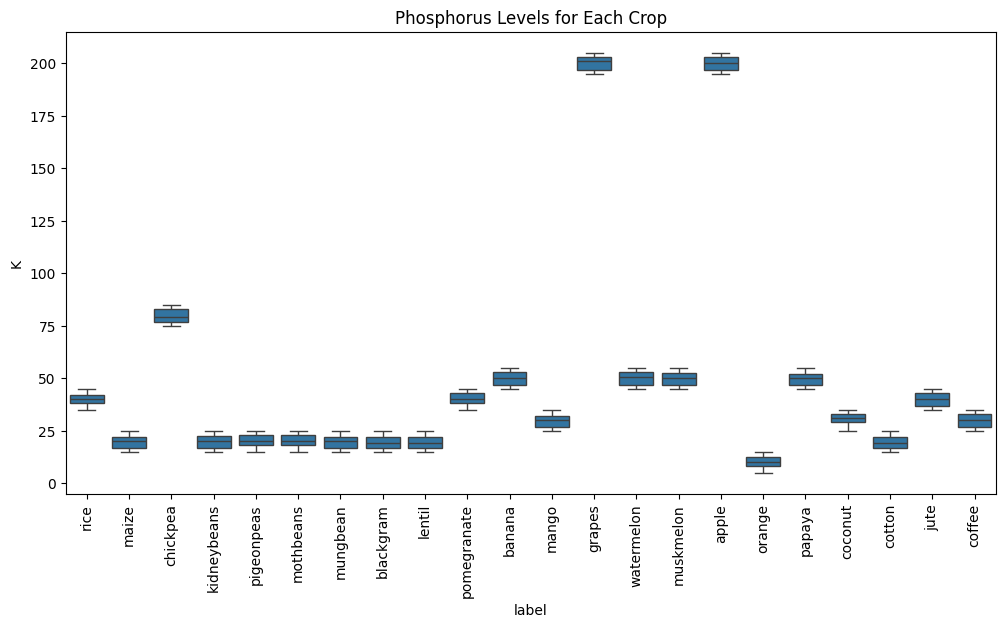

In [11]:
# Distribution of Pottassium levels for each crop
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["label"], y=df["K"])
plt.title("Phosphorus Levels for Each Crop")
plt.xticks(rotation=90)
plt.show()

The above boxplot highlights the potassium needs of various crops. Crops with higher medians require more potassium for growth, while those with lower values need less

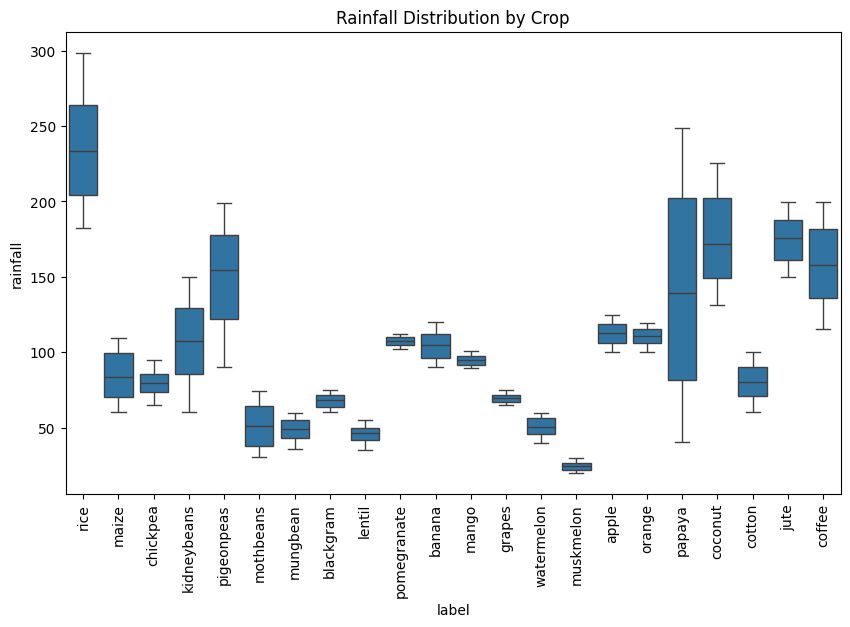

In [12]:
# Rainfall Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["label"], y=df["rainfall"])
plt.xticks(rotation=90)
plt.title("Rainfall Distribution by Crop")
plt.show()

Water-demanding crops like rice have higher rainfall needs, while drought-resistant crops like fruits require less

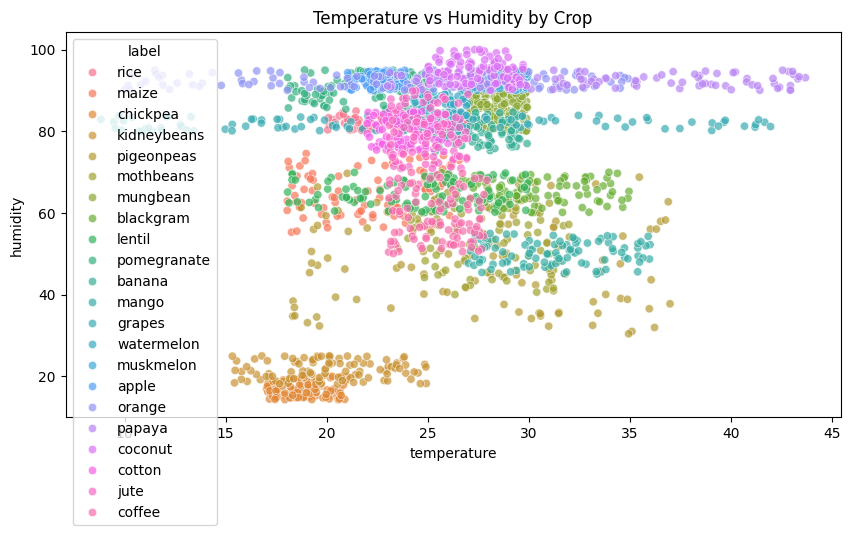

In [13]:
# Tempearture vs Humidity(scatter plot)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["temperature"], y=df["humidity"], hue=df["label"], alpha=0.7)
plt.title("Temperature vs Humidity by Crop")
plt.show()

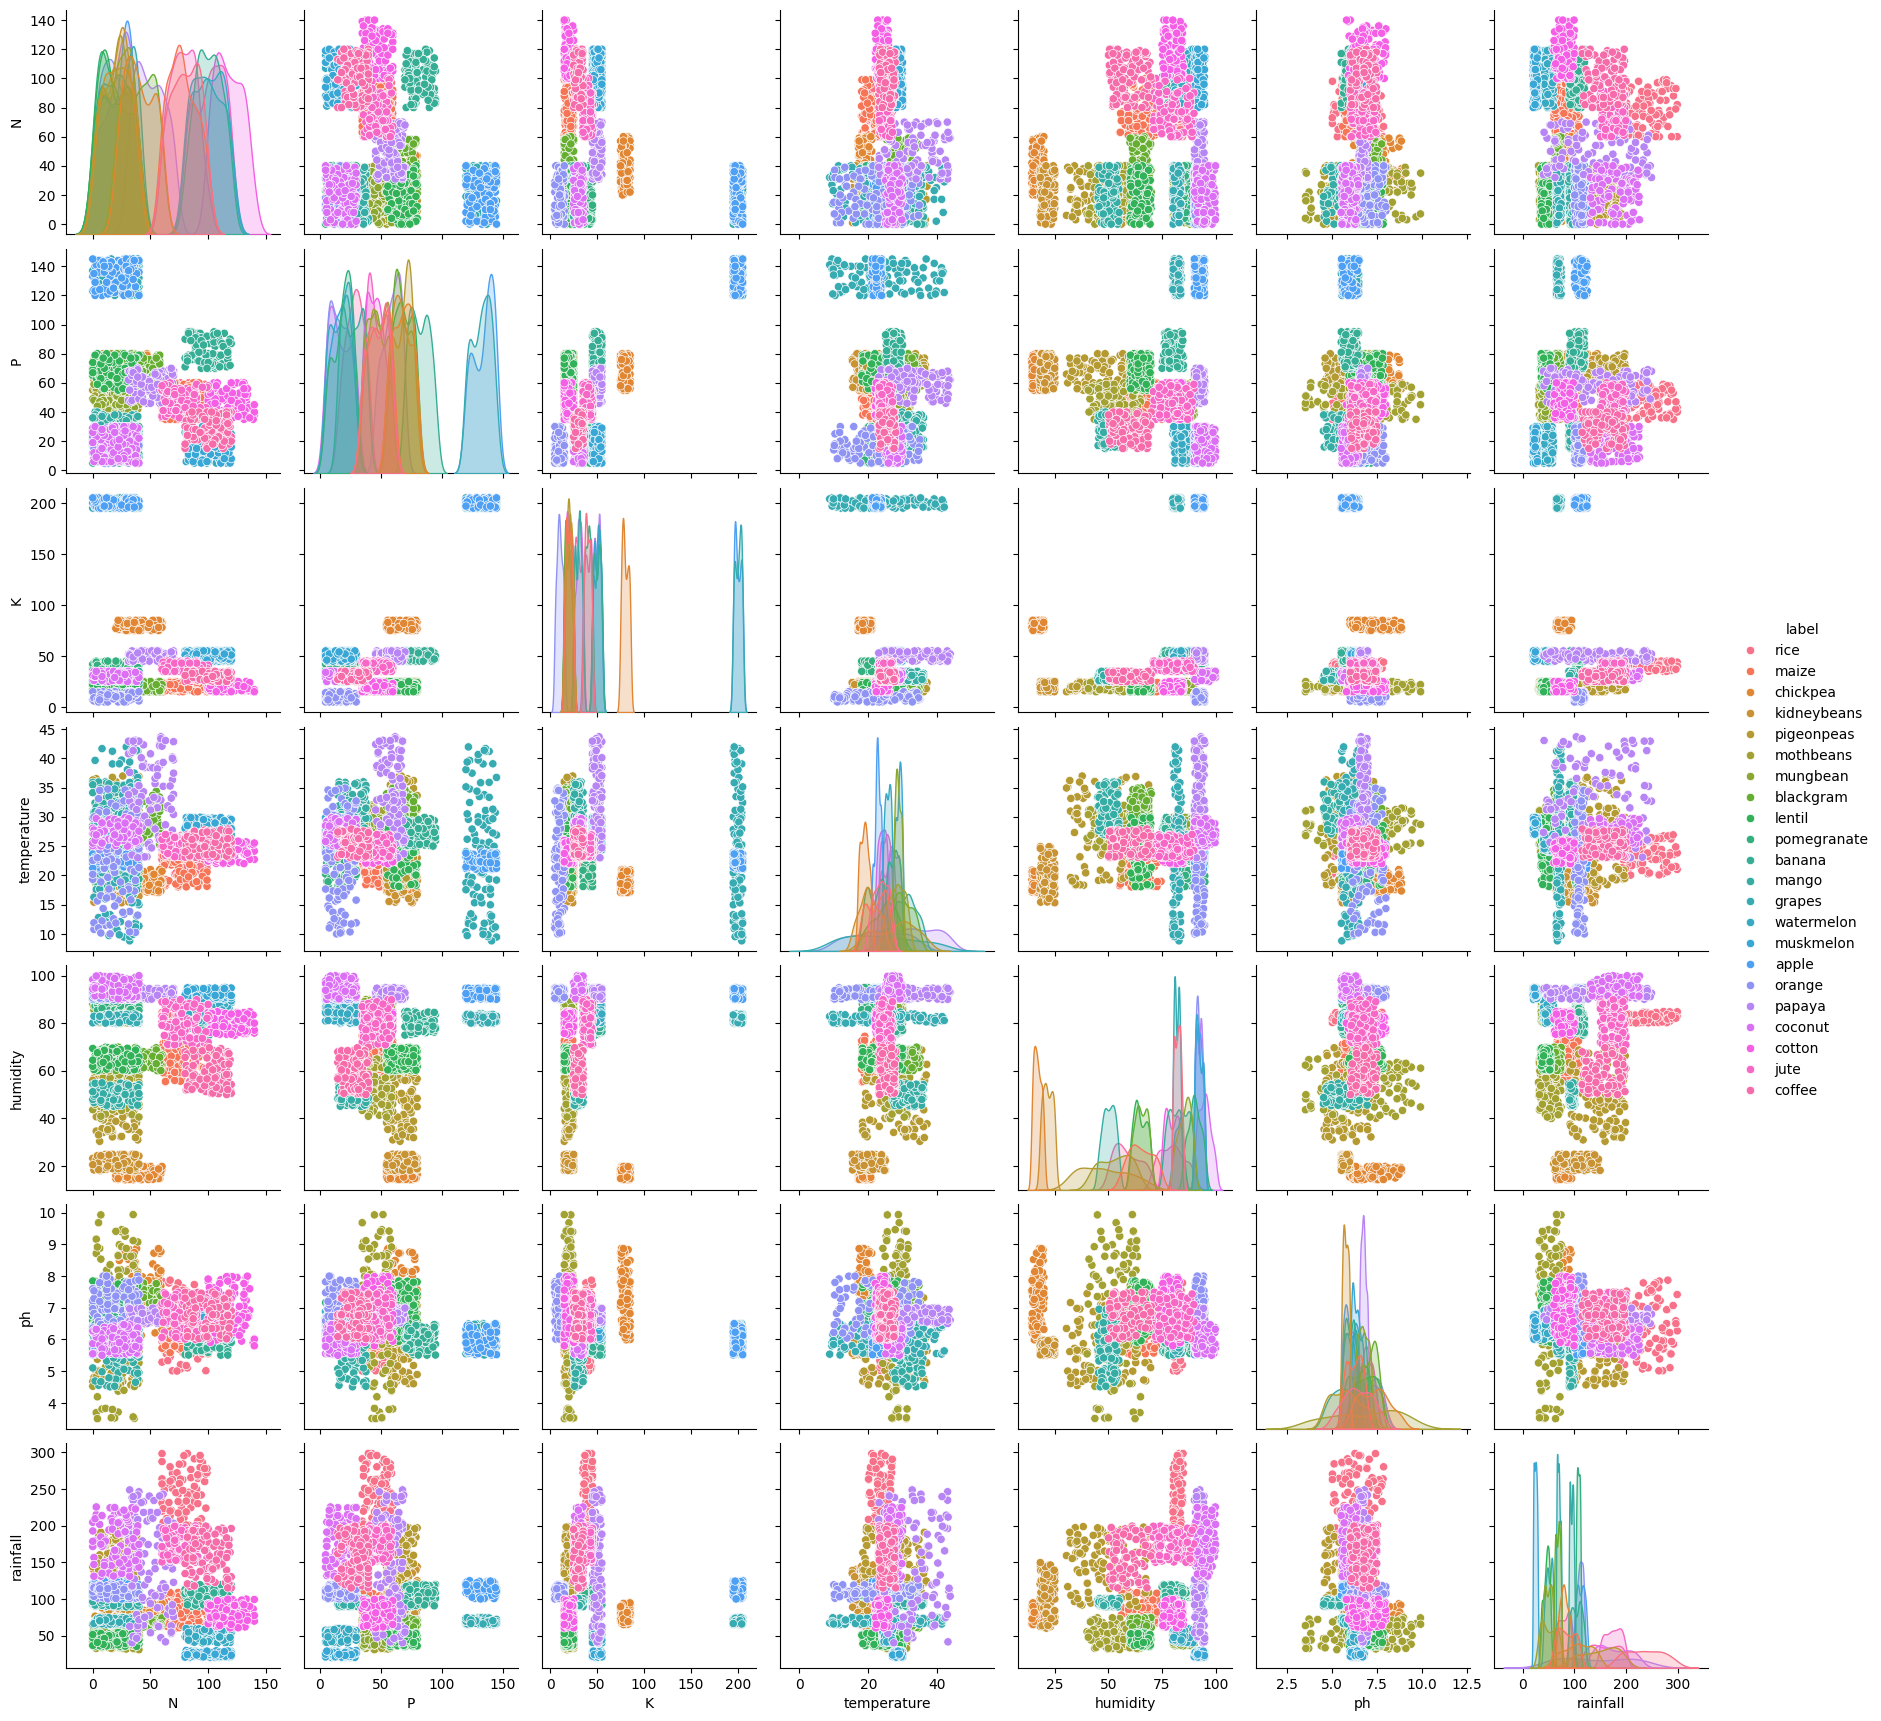

In [14]:
# Pairplot
sns.pairplot(df, hue="label", diag_kind="kde")
plt.show()

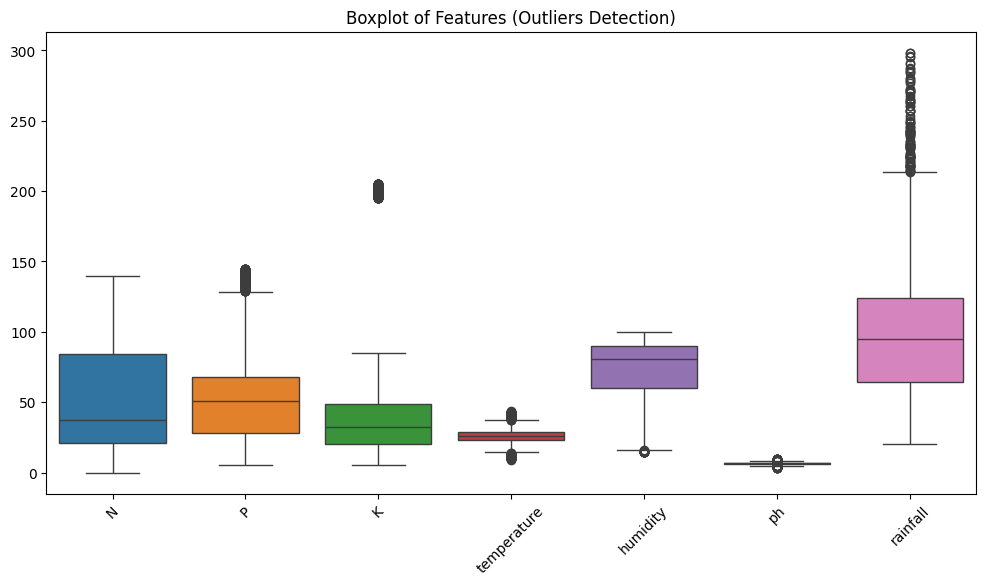

In [15]:
# Outliers Detection
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop(columns=["label"]))
plt.xticks(rotation=45)
plt.title("Boxplot of Features (Outliers Detection)")
plt.show()

From the above boxplot, we can see that outliers are present in Nitrogen, Potassium, and Rainfall levels. These variations may occur due to natural soil differences, extreme weather conditions, or measurement errors. Since some crops naturally require higher or lower nutrient levels, these outliers may still be valid.

In [16]:
# Encoding labels(Label Encoding)
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

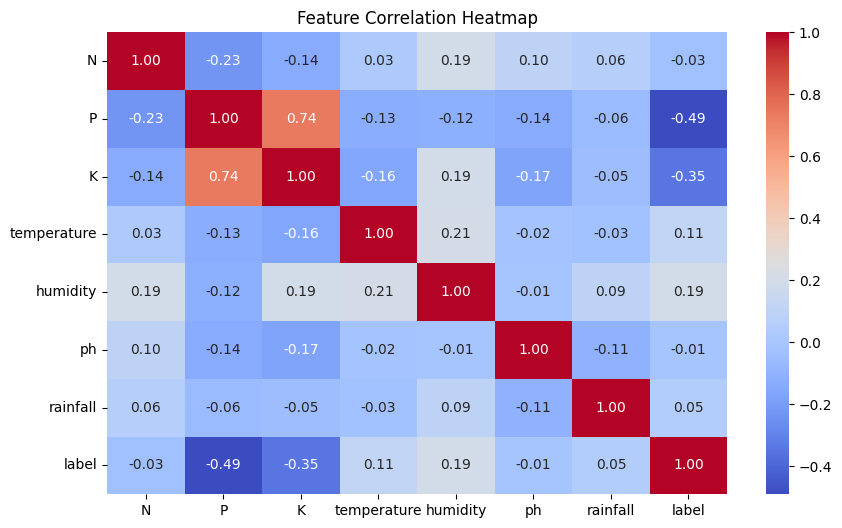

In [17]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

### Data Preprocessing

In [18]:
# Feature-Target Split
X = df.drop('label', axis=1)
y = df['label']

In [19]:
# Train Test Split(80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Feature Scaling

In [20]:
# MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Training and Evaluation

In [21]:
# Dictionary to store model accuracies
model_accuracies = {}

In [22]:
# Function to Train and Evaluate Models
def evaluate_model(model):
    model_name = model.__class__.__name__
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predictions on test data
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test,y_pred)
    
    # Store results
    model_accuracies[model_name] = acc
    
    # Display evaluation metrics
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

#### Logistic Regression

In [23]:
evaluate_model(LogisticRegression())

Accuracy: 0.9182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       0.89      0.85      0.87        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       0.94      1.00      0.97        17
           6       0.94      1.00      0.97        17
           7       1.00      1.00      1.00        14
           8       0.84      0.70      0.76        23
           9       0.91      1.00      0.95        20
          10       0.69      1.00      0.81        11
          11       1.00      0.95      0.98        21
          12       0.66      1.00      0.79        19
          13       1.00      0.54      0.70        24
          14       0.86      1.00      0.93        19
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00        14
          

#### Support Vector Classifier(SVC)

In [24]:
evaluate_model(SVC())

Accuracy: 0.9682
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       0.95      0.95      0.95        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       0.94      1.00      0.97        17
           6       0.94      1.00      0.97        17
           7       1.00      1.00      1.00        14
           8       0.81      0.96      0.88        23
           9       0.91      1.00      0.95        20
          10       0.73      1.00      0.85        11
          11       1.00      0.95      0.98        21
          12       1.00      1.00      1.00        19
          13       1.00      0.88      0.93        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00        14
          

#### Naive Bayes(GaussianNB)

In [25]:
evaluate_model(GaussianNB())

Accuracy: 0.9955
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00        14
          

#### KNN

In [26]:
evaluate_model(KNeighborsClassifier())

Accuracy: 0.9682
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       0.95      0.95      0.95        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       0.94      1.00      0.97        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.81      0.91      0.86        23
           9       0.91      1.00      0.95        20
          10       0.73      1.00      0.85        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      0.88      0.93        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.00        14
          

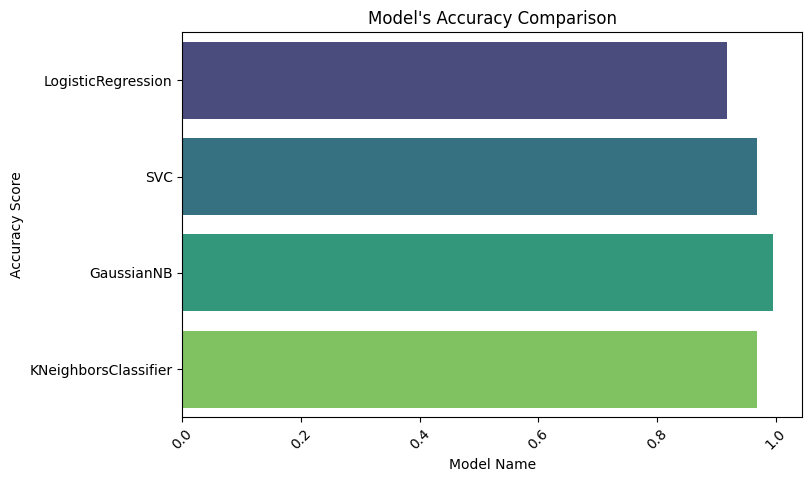

In [27]:
# Plotting Model's Accuracy
plt.figure(figsize=(8, 5))
sns.barplot(y=list(model_accuracies.keys()), x=list(model_accuracies.values()), palette="viridis")
plt.xlabel("Model Name")
plt.ylabel("Accuracy Score")
plt.title("Model's Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

From the above model comparison, we observe that **Naive Bayes** outperformed other models in terms of accuracy(99%). This indicates that the feature independence assumption of Naive Bayes aligns well with the dataset, making it a suitable choice for crop recommendation.

In [28]:
# Select the best model
best_model = GaussianNB()
best_model.fit(X_train_scaled, y_train)

GaussianNB()

### Saving the Model, Scaler and Label Encoder

In [29]:
# Save the trained model
joblib.dump(best_model, 'crop_recommendation_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save label encoder class names
joblib.dump(encoder.classes_, 'label_classes.pkl')

['label_classes.pkl']

### Building a Predictive System

In [30]:
# Loading the model, scaler, and label classes
loaded_model = joblib.load('crop_recommendation_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')
label_classes = joblib.load('label_classes.pkl')

# Sample input 
sample_input = [[107, 34, 32, 26.7, 66.4, 6.8, 177.7]]

# Scaling the input
sample_input_scaled = loaded_scaler.transform(sample_input)

# Predicting crop (numerical label)
predicted_label = loaded_model.predict(sample_input_scaled)[0]

# Converting label to crop name
predicted_crop = label_classes[predicted_label]

print(f"Recommended Crop: {predicted_crop}")

Recommended Crop: coffee
